# <ins> HeartRate Detection Algorithm </ins>

#### PPG (Photoplethysmography):
Photoplethysmography (PPG) is a non-invasive method of measuring blood volume changes in tissues using light. It works by shining light into the skin and measuring the amount of light absorbed or reflected by the blood vessels. PPG can be used to measure heart rate, oxygen saturation, and blood pressure. It is commonly used in pulse oximeters, wearable fitness trackers, and other medical devices. PPG signals are typically acquired at a sampling frequency of 50-1000 Hz and can be analyzed using signal processing techniques such as filtering, peak detection, and frequency analysis. PPG is a simple and inexpensive method of monitoring cardiovascular health and has a wide range of applications in both clinical and non-clinical settings.

### PPG Raw Data: https://physionet.org/content/pulse-transit-time-ppg/1.0.0/
This is high resolution and time synchronised dataset from multiple sensors worn at different body locations including Photoplethysmogram (PPG), Inertial, Pressure and ECG. The recordings are from 22 healthy subjects performing 3 physical activities. This dataset contains 66 waveform records from multi-site and multi-wavelength PPGs, sensors’ attachment pressures, sensors’ temperatures, inertial data from accelerometer and gyroscope, along with annotated ECG data for a total of 19 channels.

Channels:
pleth_1: MAX30101 red wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (500Hz)</br>
pleth_2: MAX30101 infrared wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (500Hz)</br>
pleth_3: MAX30101 green wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (500Hz)</br>
pleth_4: MAX30101 red wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (500Hz)</br>
pleth_5: MAX30101 infrared wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (500Hz)</br>
pleth_6: MAX30101 green wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (500Hz)</br>

### Algorithm:
Step0: Get Raw PPG signal </br>
Step1: Filter the PPG signal with a bandpass filter.</br>
Step2: Check signal quality by calculating Signal to Noise Ratio. </br>
Step3: Differentiate the filtered signal </br>
Step4: Square the differentiated  signal. </br>
Step5: Integrate the squared signal with a sliding window. </br>
Step6: Find the R-peaks in the integrated signal. </br>
Step7: Calculate the heart rate using the time difference between R-peaks. </br>

### Step0: Get Raw PPG signal

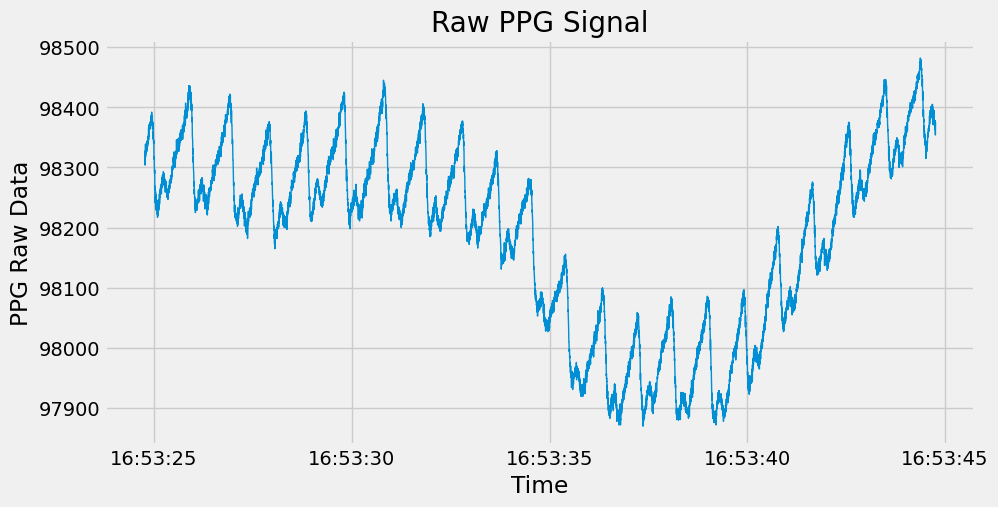

In [17]:
# Project Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks

# Select channel from the dataset.
channel = 'pleth_5'

df = pd.read_csv('PPG_Dataset/s3_sit.csv')
df.head()

# Data Sampled at 500Hz
# Getting 20 Seconds of raw data
ppg_data = df[['time', channel]].iloc[:10000]

# Convert the time column to a datetime object
ppg_data['time'] = pd.to_datetime(ppg_data['time'], format='%Y-%m-%d %H:%M:%S.%f')

# Set the time column as the dataframe index
ppg_data.set_index('time', inplace=True)

# Plot the PPG data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Raw PPG Signal")
plt.xlabel('Time')
plt.ylabel('PPG Raw Data')
plt.show()


 ### <ins> Step1: Filter the PPG signal with a bandpass filter.</br> </ins>
The purpose of filtering is to remove noise and unwanted components from the signal. A bandpass filter is used to pass only the frequency band of interest, which in this case is the heart rate. A typical bandpass filter used for PPG signals has a passband between 0.5 Hz and 5 Hz.

Cut off Frequency fc:</br>
PPG signal contains information mostly in rage of 0.5Hz(30bpm) to 5Hz(300bpm). In our application in most of cases choosing Fc = 5Hz gives us the best results since majority of the time heart rate range can't go outside between 30bpm(0.5Hz) to 300bpm(5Hz) so choosing 5Hz as cutoff frequency gives us best result. 

Sampling Frequency fs:</br>
Here we in this dataset data is sampled at 500Hz. So for this data Sampling frequency would be 500Hz. That means there are 10000 samples in 20 seconds time period. This we can confirmed by above plot as we can clearly see 10,000 samples are perfectly alighneg with 20 seconds. You can also confirm this manually in the dataset. 


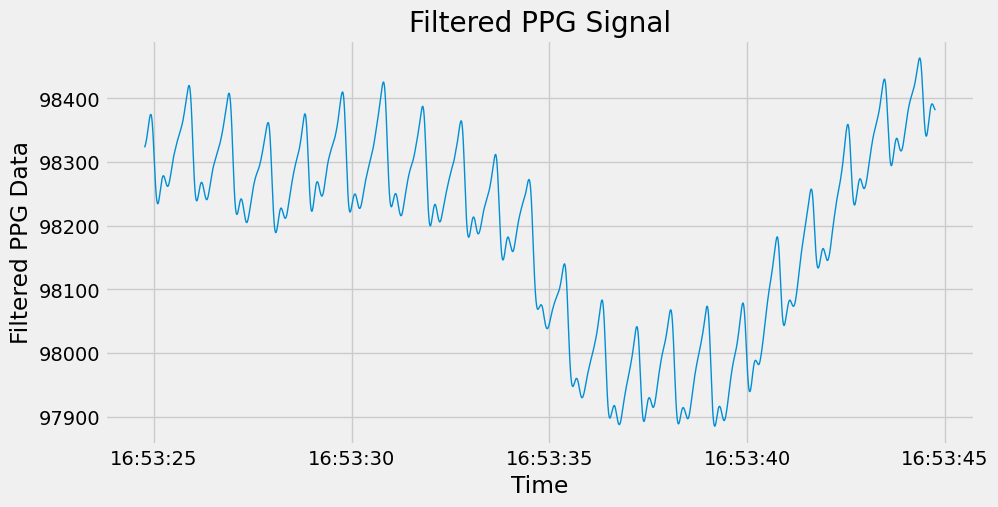

In [18]:
# Low-pass filter the raw signal to remove noise
fs = 500  # Sampling frequency
fc =  5 # Cutoff frequency
b, a = butter(2, 2 * fc / fs, 'low')

ppg_data_raw = ppg_data[channel]
#Applying LP Filter to ppg_data[channel]
ppg_data[channel] = filtfilt(b, a, ppg_data[channel])

ppg_data_filtered = ppg_data[channel]

# Plot the filtered_ppg data
plt.figure(figsize=(10,5))
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Filtered PPG Signal")
plt.xlabel('Time')
plt.ylabel('Filtered PPG Data')
plt.show()

### <ins> Step2: Check signal quality by calculating Signal to Noise Ratio. </br> </ins>
If Signal SNR is more than 25dB we consider it as good signal. If it falls below 25dB we give error.  

In [19]:
# Calculating SNR to find quality of a signal
# Noise signal
THRESHOLD = 25      #dB
noise_data = ppg_data_raw - ppg_data_filtered

signal_power = np.mean(np.abs(ppg_data_filtered)**2)
noise_power = np.mean(np.abs(noise_data)**2)
SNR = 10*np.log10(signal_power/noise_power)
print("SNR: ", SNR)
if SNR < THRESHOLD:
    print("Signal Quality is Bad!")
else: 
    print("Signal Quality is Good!")

SNR:  81.27021120264958
Signal Quality is Good!


### <ins> Step3: Differentiate the filtered signal </ins>
By differentiating the filtered PPG signal, we can enhance the QRS complex in the PPG signal, which can help in detecting the heartbeat accurately. The differentiation operation also introduces noise into the signal, which can be reduced using a smoothing operation like moving average or median filtering. 

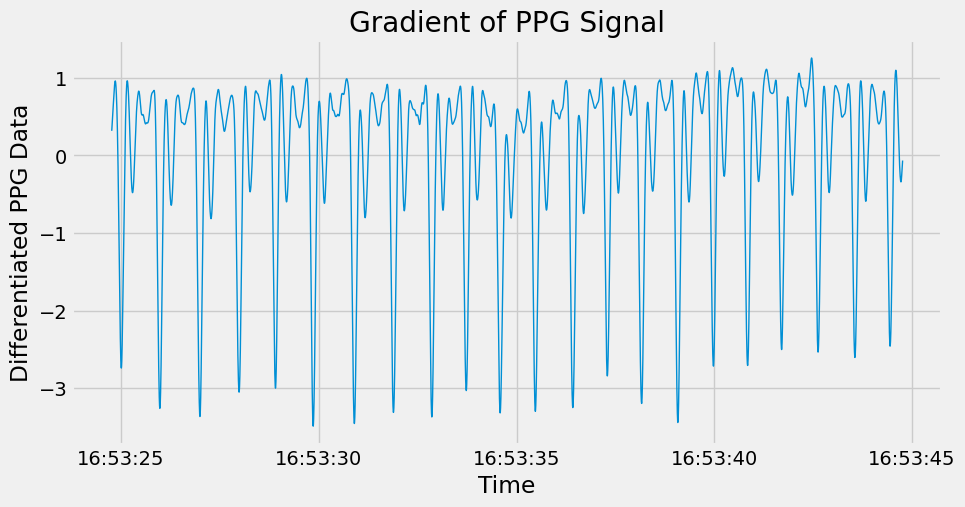

In [20]:
# Differentiate the filtered signal to emphasize the high-frequency components
ppg_data[channel] = np.gradient(ppg_data[channel])

# Plot the diff_ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Gradient of PPG Signal")
plt.xlabel('Time')
plt.ylabel('Differentiated PPG Data')
plt.show()

### <ins> Step4: Square the differentiated  signal. </br> </ins>
Squaring the differentiated signal after it enhances the high-frequency components of the QRS complex and suppresses other low-frequency components in the signal, which improves the detection of the QRS complex in the signal. The squared signal produces prominent peaks where the QRS complex is located, which simplifies the detection process.

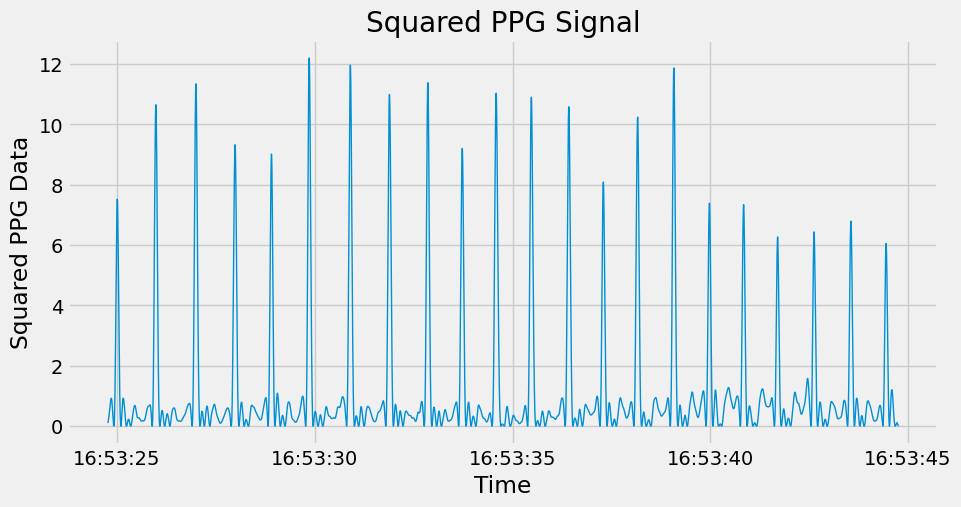

In [21]:
# Square the differentiated signal to enhance QRS complex
ppg_data[channel] = np.square(ppg_data[channel])
# Plot the square ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Squared PPG Signal")
plt.xlabel('Time')
plt.ylabel('Squared PPG Data')
plt.show()

### <ins> Step5:  Integrate the squared signal with a sliding window. </br> </ins>
The purpose of this step is to smooth the signal and amplify the QRS complex even further. Here we have taken 50 window size means we can take moving average of 50 samples. 

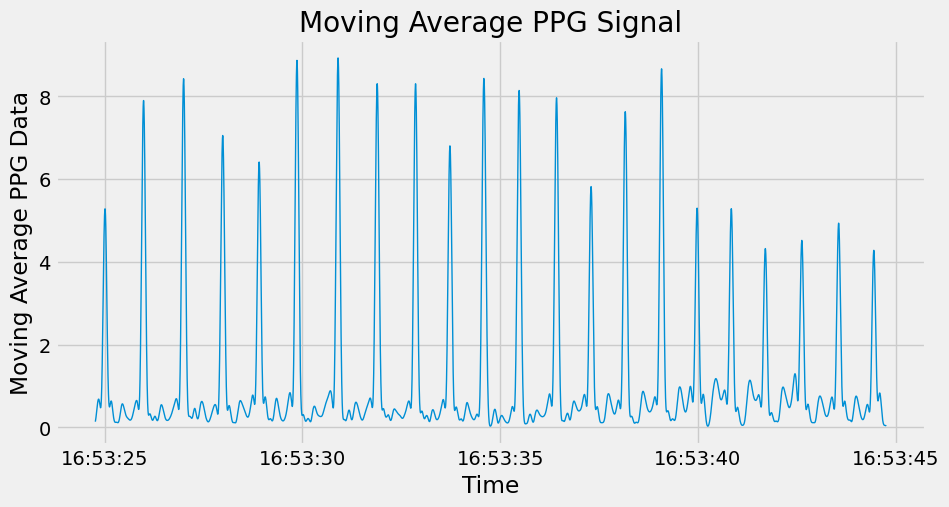

In [22]:
# Apply a moving average integration to smooth the signal
window_size = int(0.1 * fs)  # 50 window size
window = np.ones(window_size) / float(window_size)
ppg_data[channel] = np.convolve(ppg_data[channel], window, "same")

# Plot the diff_ppg data
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')
plt.plot(ppg_data.index, ppg_data[channel], linewidth=1)
plt.title("Moving Average PPG Signal")
plt.xlabel('Time')
plt.ylabel('Moving Average PPG Data')
plt.show()

### <ins> Step6: Find the R-peaks in the integrated signal. </br> </ins>
R peaks correspond to the highest point in the QRS complex, so we find the R peaks in the filtered signal to identify the location of each heartbeat. For this we can find_peaks() method which will return x axis positions of each peaks. Which we can use to calculate Inter Beat Interval(IBI)

In [23]:
# Find peaks in the integrated signal
ppg_peaks, _ = find_peaks(ppg_data[channel], distance=0.2*fs)
print("ppg_peaks:", ppg_peaks)
print("ppg_peaks size:", ppg_peaks.size)

# Get a list of Amplitude of peaks
ppg_peaks_amplitudes = [ppg_data[channel][i] for i in ppg_peaks]
# print("ppg_peaks_amplitudes:", ppg_peaks_amplitudes)
print("ppg_peaks_amplitudes size:", len(ppg_peaks_amplitudes))

max_peak_amplitude = max(ppg_peaks_amplitudes)
print("max_peak_amplitude:", max_peak_amplitude)
PEAK_AMPLITUDE_THRESHOLD = 0.20*max_peak_amplitude
print("PEAK_AMPLITUDE_THRESHOLD:", PEAK_AMPLITUDE_THRESHOLD)

ppg_peaks_refined = []
for ppg_peak in ppg_peaks:
    if(ppg_data[channel][ppg_peak] > PEAK_AMPLITUDE_THRESHOLD):
        # Amplitude is big enough to be considered as a peak
        ppg_peaks_refined.append(ppg_peak)

print(ppg_peaks_refined)

ppg_peaks: [ 122  342  610  835 1116 1345 1610 1833 2071 2291 2549 2769 3069 3295
 3563 3781 4048 4267 4483 4700 4913 5051 5357 5583 5831 6052 6267 6487
 6700 6924 7159 7389 7608 7845 8040 8275 8470 8694 8932 9161 9397 9619
 9842]
ppg_peaks size: 43
ppg_peaks_amplitudes size: 43
max_peak_amplitude: 8.924283844677392
PEAK_AMPLITUDE_THRESHOLD: 1.7848567689354784
[122, 610, 1116, 1610, 2071, 2549, 3069, 3563, 4048, 4483, 4913, 5357, 5831, 6267, 6700, 7159, 7608, 8040, 8470, 8932, 9397, 9842]


### <ins> Step7: Calculate the heart rate using the time difference between R-peaks. </br> </ins>


In [24]:

# Compute the inter-beat interval (IBI) and heart rate (HR) from the peak locations
ibi = np.diff(ppg_peaks_refined) / fs  # IBI in seconds
hr = 60 / ibi  # HR in bpm

mean_hr = np.mean(hr)

HEARTRATE_LOWER_THRESHOLD = 25
HEARTRATE_HIGHER_THRESHOLD = 300
if (mean_hr < HEARTRATE_LOWER_THRESHOLD) or (mean_hr > HEARTRATE_HIGHER_THRESHOLD):
    print("Heart rate for file sample_ppg.csv: Error")
else:        
    # Output the heart rate measurement
    print("Heart rate for file sample_ppg.csv:", np.mean(hr), "bpm")

Heart rate for file sample_ppg.csv: 65.02587360803275 bpm
